# Time Series Forecasting 

### Table of Contents:
* [Exponential Smoothing](#)
* [ARIMA](#)
* [Gradient Boosted Trees](#)
* [Box-Cox Transform](#qq-plot)

References:
* [Forecasting: Principles and Practice](https://otexts.com/fpp2/)
* [ARIMA models for time series forecasting](https://people.duke.edu/~rnau/411arim.htm#pdq)
* [statsmodels.org](https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html)
* [LightGBM](https://lightgbm.readthedocs.io/en/stable/Parameters-Tuning.html)

### Generate Data with linear trend with a cyclic pattern and random noise

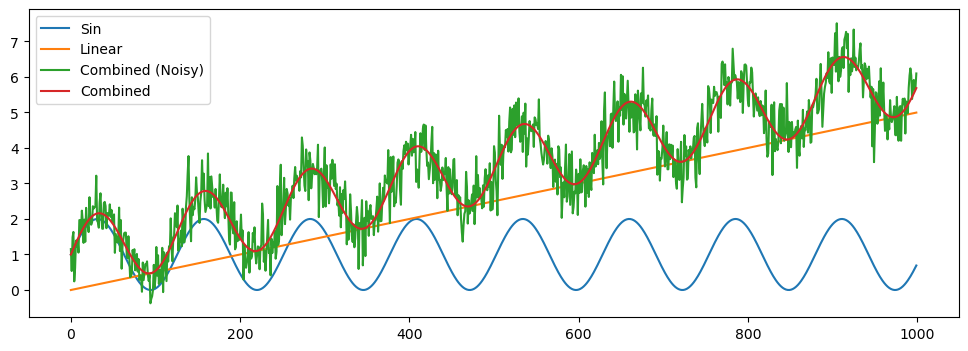

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
import lightgbm as lgb

FIGSIZE = (12, 4)

data_size = 1000
sin = 1 + np.sin(np.arange(data_size)*.05)
linear = np.arange(data_size)*.005
combined = sin + linear

rng = np.random.default_rng(42)
noisy_data = combined + rng.normal(scale=0.5, size=data_size)

# Split the data into train and test sets
train_size = int(data_size * 0.8)
test_size = data_size - train_size
train, test = combined[:train_size], combined[train_size:]
noisy_train, noisy_test = noisy_data[:train_size], combined[train_size:]

plt.figure(figsize=FIGSIZE)
plt.plot(sin, label='Sin')
plt.plot(linear, label='Linear')
plt.plot(noisy_data, label='Combined (Noisy)')
plt.plot(combined, label='Combined')
plt.legend()
plt.show()

### Seasonality 
This is data dependent. For example, if you have daily data and a weekly trend in the data, then the seasonality parameter will be 7.

Here I find the seasonality by looking at when the sin function repeats.

Average distance between peaks: 126


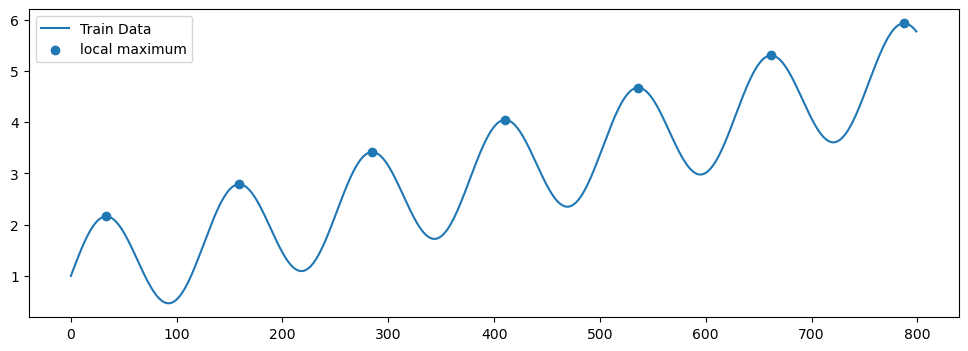

In [64]:
peaks = [i for i in range(1, len(train)-1) if train[i] > train[i-1] and train[i] > train[i+1]]
print(f"Average distance between peaks: {round(sum(list(map(lambda x1, x2: x2-x1, peaks[:-1], peaks[1:]))) / len(peaks[:-1]))}")
plt.figure(figsize=FIGSIZE)
plt.plot(train, label='Train Data')
plt.scatter(peaks, train[peaks], label='local maximum')
plt.legend()
plt.show()

# Exponential Smoothing 
$ S_t = \alpha  y_t + (1 - \alpha) S_{t-1} $, where
- $ S_t $ is the smoothed value at time $ t $
- $ y_t $ is the actual value at time $ t $
- $ \alpha $ is the smoothing parameter, $ 0 \leq \alpha \leq 1 $

<br>
Simple exponential smoothing won't be able to capture any of the trends on the data :(

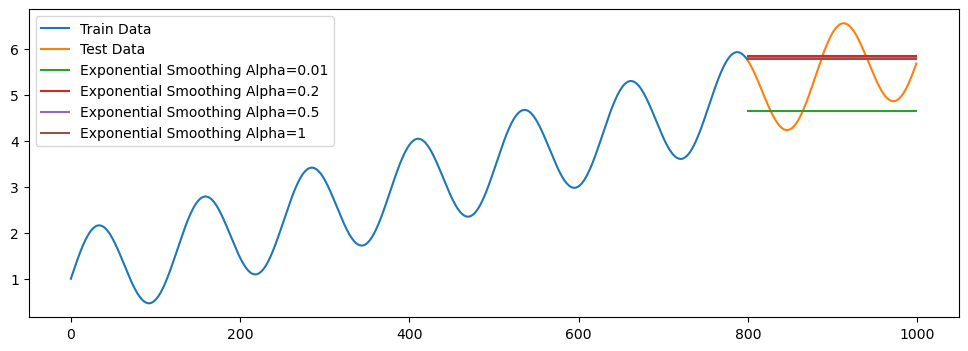

In [66]:
plt.figure(figsize=FIGSIZE)
plt.plot(train, label='Train Data')
plt.plot(np.arange(train_size, data_size), test, label='Test Data')

for alpha in [0.01, 0.2, 0.5, 1]:
    exp_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha, optimized=False)
    exp_smoothing_forecast = exp_model.forecast(test_size)
    plt.plot(np.arange(train_size, data_size), exp_smoothing_forecast, label=f'Exponential Smoothing Alpha={alpha}')

plt.legend()
plt.show()

## Exponential smoothing with seasonality (Holt-Winters)


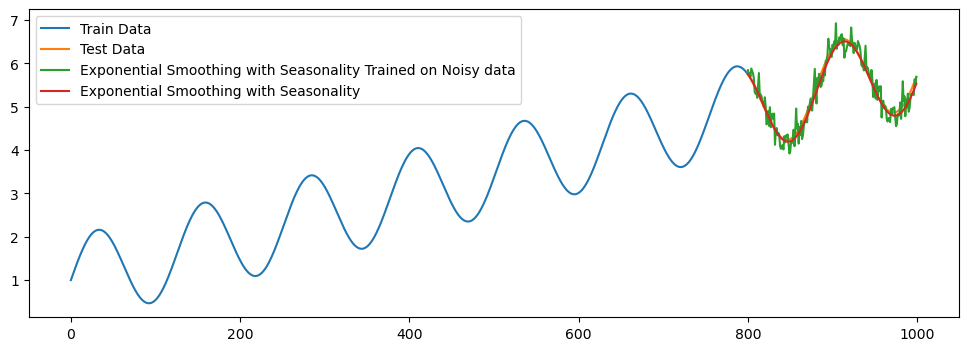

In [80]:
plt.figure(figsize=FIGSIZE)
plt.plot(train, label='Train Data')
plt.plot(np.arange(train_size, data_size), test, label='Test Data')

exp_model = ExponentialSmoothing(noisy_train,
                seasonal_periods=126,
                trend="add",
                seasonal="add").fit()
exp_smoothing_forecast = exp_model.forecast(test_size)
plt.plot(np.arange(train_size, len(combined)), exp_smoothing_forecast, label=f'Exponential Smoothing with Seasonality Trained on Noisy data')

exp_model = ExponentialSmoothing(train,
                seasonal_periods=126,
                trend="add",
                seasonal="add").fit()
exp_smoothing_forecast = exp_model.forecast(test_size)
plt.plot(np.arange(train_size, len(combined)), exp_smoothing_forecast, label=f'Exponential Smoothing with Seasonality')
plt.legend()
plt.show()

## Model decomposition

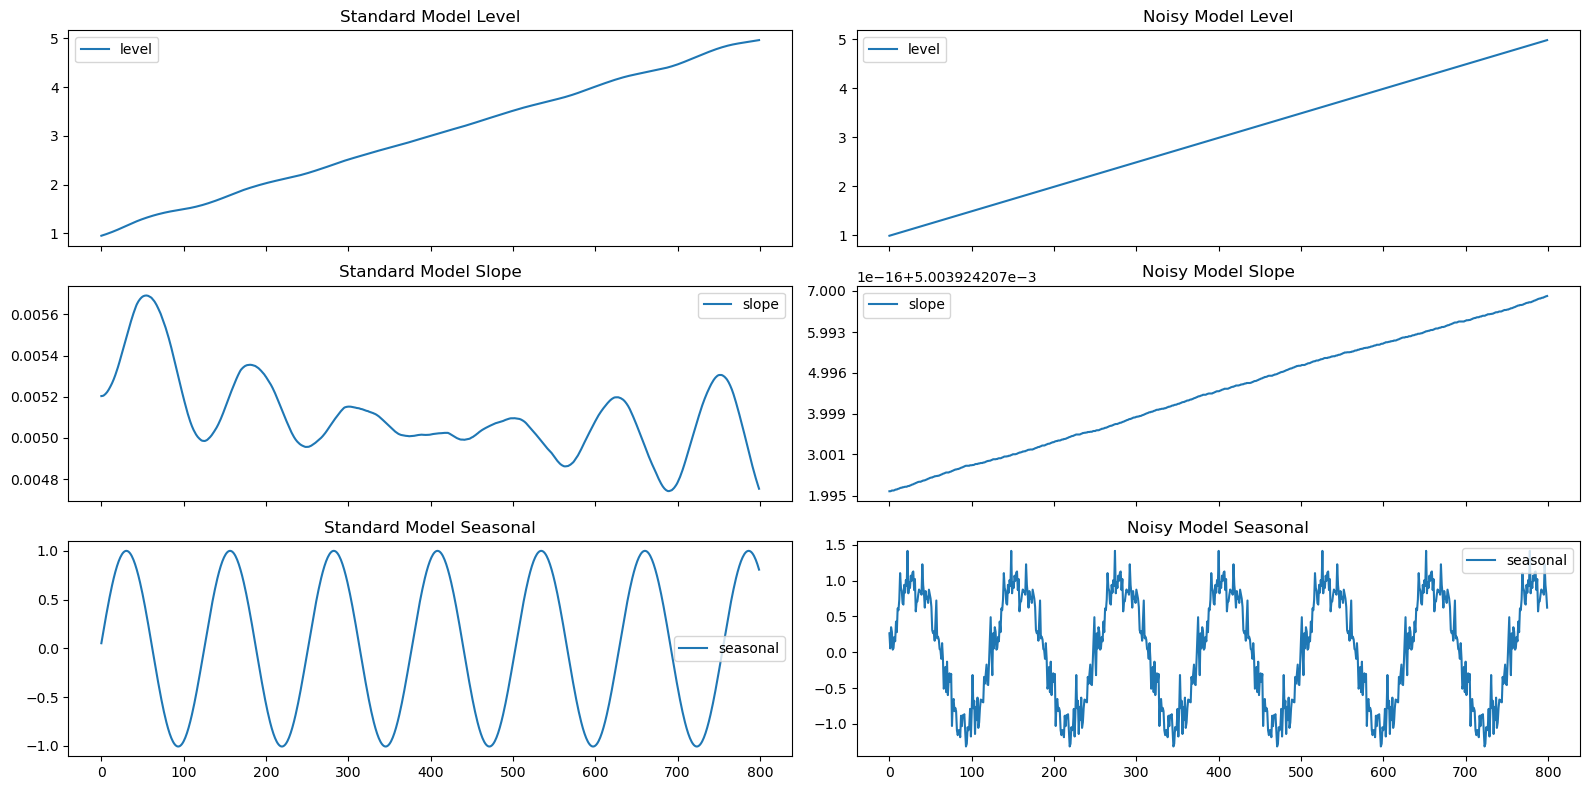

In [75]:
noisy_exp_model = ExponentialSmoothing(noisy_train,
                seasonal_periods=126,
                trend="add",
                seasonal="add").fit()

exp_model = ExponentialSmoothing(train,
                seasonal_periods=126,
                trend="add",
                seasonal="add").fit()

# Create data frames for each model
noisy_states = pd.DataFrame(
    np.c_[noisy_exp_model.level, noisy_exp_model.trend, noisy_exp_model.season],
    columns=["level", "slope", "seasonal"]
)

standard_states = pd.DataFrame(
    np.c_[exp_model.level, exp_model.trend, exp_model.season],
    columns=["level", "slope", "seasonal"]
)

fig, axes = plt.subplots(3, 2, figsize=(16, 8), sharex=True)
standard_states[["level"]].plot(ax=axes[0, 0], title="Standard Model Level")
standard_states[["slope"]].plot(ax=axes[1, 0], title="Standard Model Slope")
standard_states[["seasonal"]].plot(ax=axes[2, 0], title="Standard Model Seasonal")
noisy_states[["level"]].plot(ax=axes[0, 1], title="Noisy Model Level")
noisy_states[["slope"]].plot(ax=axes[1, 1], title="Noisy Model Slope")
noisy_states[["seasonal"]].plot(ax=axes[2, 1], title="Noisy Model Seasonal")
plt.tight_layout()
plt.show()

## ARIMA / SARIMAX(p, d, q)x(P, D, Q, s)

Parameters:
* **AutoRegressive (p)**: Relationship between an observation and a certain number of lagged observations (previous time steps). The parameter p determines the number of lag observations included in the model.
* **Integrated (d)**: Order of differencing required to make the series stationary. Differencing is the transformation of a time series to remove trends and seasonality, and d is the number of times the differencing operation is performed.
* **Moving Average (q)**: Relationship between an observation and a residual error from a moving average model applied to lagged observations. The parameter q specifies the number of terms.

Seasonal components:
* **Seasonal AR (P)**: Similar to the AR but apply to the seasonal component of the series. The parameter P specifies the number of seasonal autoregressive terms.
* **Seasonal differencing order (D)**: How many seasonal differences are needed to make the series stationary.
* **Seasonal MA (Q)**: MA for the seasonal differences. Q specifies the number of seasonal moving average terms.
* **Seasonal period (s)**: Length of the seasonal cycle. E.g. s=12 for monthly data with an annual cycle.

Other:
* **Exogenous variables (X)**: External variables that influence the forecast but are not predicted by the model. They can include any variable thought to affect the dependent variable, such as economic indicators, weather conditions, etc.

ARIMA(0,1,1) without constant = simple exponential smoothing


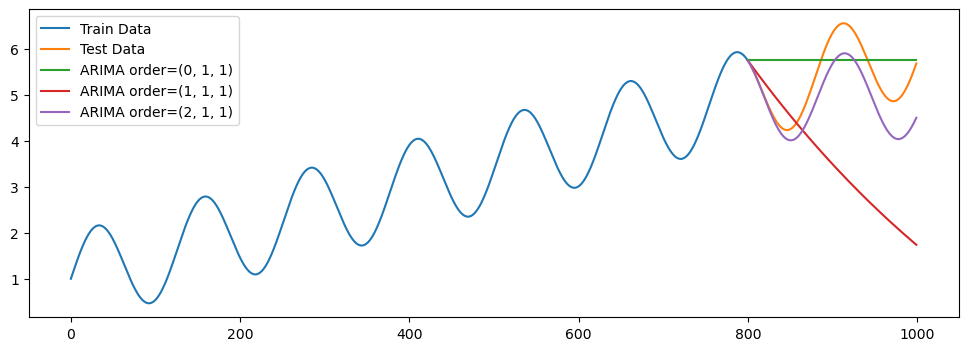

In [54]:
def ARIMA_forecast(model):
    arima_fit = model.fit(method_kwargs={"warn_convergence": False})
    return arima_fit.forecast(len(test))

plt.figure(figsize=FIGSIZE)
plt.plot(train, label='Train Data')
plt.plot(np.arange(train_size, len(combined)), test, label='Test Data')
plt.plot(np.arange(train_size, len(combined)), ARIMA_forecast(ARIMA(train, order=(0, 1, 1))), label='ARIMA order=(0, 1, 1)')
plt.plot(np.arange(train_size, len(combined)), ARIMA_forecast(ARIMA(train, order=(1, 1, 1))), label='ARIMA order=(1, 1, 1)')
plt.plot(np.arange(train_size, len(combined)), ARIMA_forecast(ARIMA(train, order=(2, 1, 1))), label='ARIMA order=(2, 1, 1)')
plt.legend()
plt.show()

/Users/jordanbarker/miniconda3/envs/py311/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


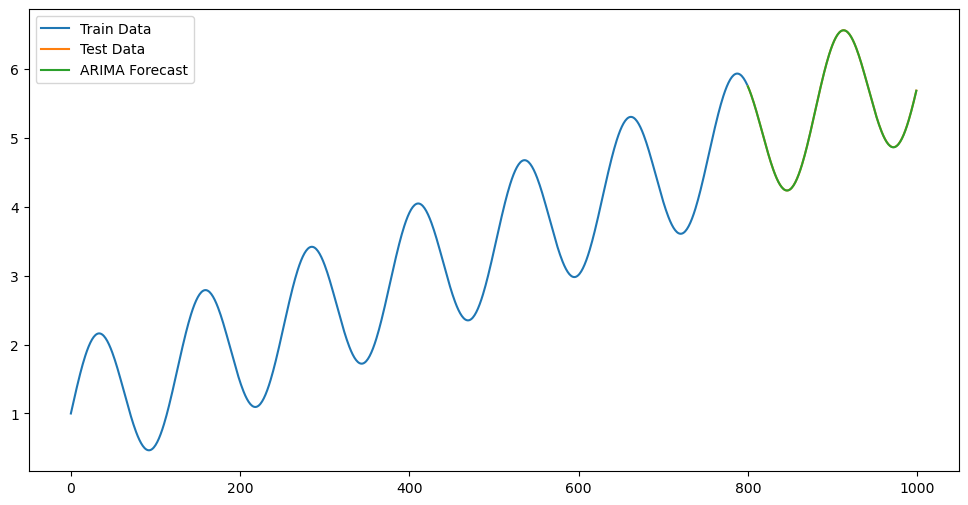

In [43]:
# arima_model = ARIMA(train, order=(1, 1, 1))
arima_model = ARIMA(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 126))
arima_fit = arima_model.fit(method_kwargs={"warn_convergence": False})
arima_forecast = arima_fit.forecast(len(test))

plt.figure(figsize=(12, 6))
plt.plot(train, label='Train Data')
plt.plot(np.arange(train_size, len(combined)), test, label='Test Data')
plt.plot(np.arange(train_size, len(combined)), arima_forecast, label='ARIMA Forecast')
plt.legend()
plt.show()

In [ ]:
# sarimax_model = SARIMAX(train, order=(2, 1, 1))
# sarimax_fit = sarimax_model.fit()
# sarimax_forecast = sarimax_fit.forecast(len(test))
# plt.plot(np.arange(train_size, len(combined)), sarimax_forecast, label='SARIMAX Forecast')
# plt.plot(np.arange(train_size, len(combined)), test, label='Test Data')

# LightGBM
We can turn the forecasting data into tabular form by creating lag features.

Tree based models cannot make predictions outside of the training data. Below we see the result of this by finding that the model won't predict a value higher than what was previously observed

In [ ]:
'''
Parameter Tuning
'''
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'boosting_type': ['gbdt', 'dart'],
#     'metric': ['l2'],
#     'learning_rate': [0.05, 0.1, 0.2],
#     'num_leaves': [5, 10, 20, 40],
#     'feature_fraction': [0.5, 0.9, 0.95, 1],
#     'bagging_fraction': [0.5, 0.9, 0.95, 1],
#     'lambda_l1': [0, 0.1, 0.2],
#     'lambda_l2': [0, 0.1, 0.2],
#     'min_gain_to_split': [0.01, 0.1, 0.2],
#     'verbose': [-1]
# }

# gbm = lgb.LGBMRegressor()
# grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, scoring='neg_mean_squared_error')
# grid_search.fit(X_train, y_train)

# print("Best parameters found by grid search are:", grid_search.best_params_)

,data,t_1,t_2,t_3,t_4
0,1.000000,NaN,NaN,NaN,NaN
1,1.054979,1.000000,NaN,NaN,NaN
2,1.109833,1.054979,1.000000,NaN,NaN
3,1.164438,1.109833,1.054979,1.000000,NaN
4,1.218669,1.164438,1.109833,1.054979,1.0


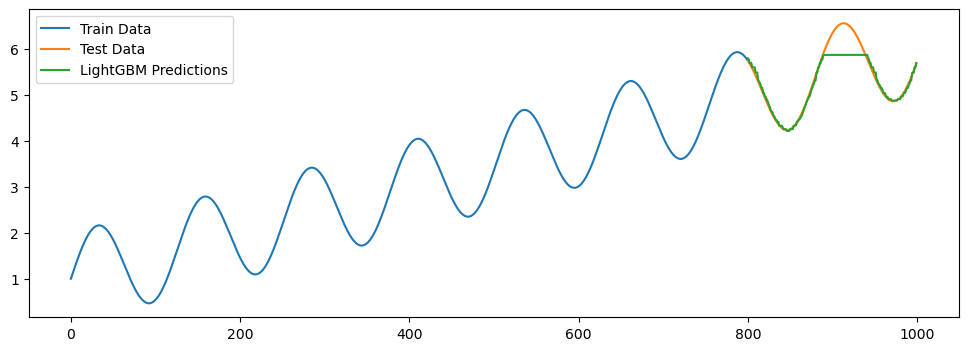

In [45]:
df = pd.DataFrame({'data': combined})
for lag in range(1, 5):
    df[f't_{lag}'] = df['data'].shift(lag)

X = df.drop('data', axis=1)
y = df['data']

X_train, X_test = X[:train_size], X[train_size:] 
y_train, y_test = y[:train_size], y[train_size:] 

display(df.head())

params = {'bagging_fraction': 0.5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'lambda_l1': 0, 'lambda_l2': 0.2, 'learning_rate': 0.2, 'metric': 'l2', 'min_gain_to_split': 0.01, 'num_leaves': 20, 'objective': 'regression', 'verbose': -1}
lgb_train = lgb.Dataset(X_train, y_train)
gbm = lgb.train(params, lgb_train)
predictions = gbm.predict(X_test)

plt.figure(figsize=FIGSIZE)
plt.plot(train, label='Train Data')
plt.plot(np.arange(train_size, data_size), test, label='Test Data')
plt.plot(np.arange(train_size, data_size), predictions, label=f'LightGBM Predictions')
plt.legend()
plt.show()

# Box-Cox Transformation
Transforms the target variable so that data resembles a normal distribution which is assumed by many models.

Cons:
* Harder to interprete
* Usually gives the median of the forecast distribution when we revert the transformed data to its original scale.

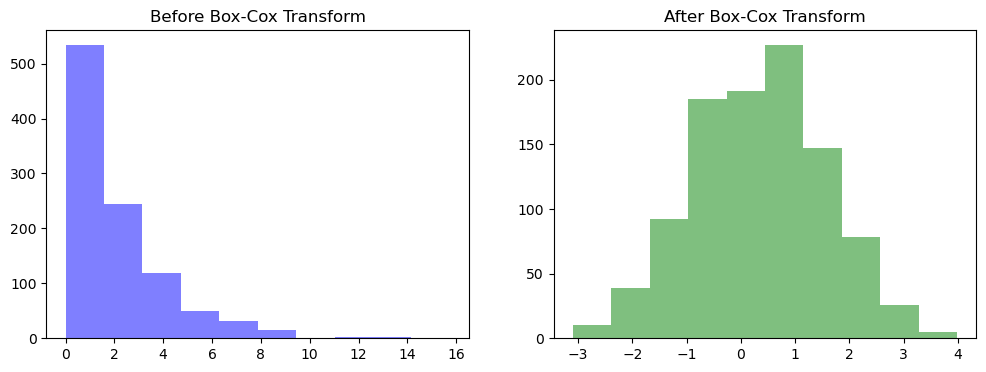

In [57]:
from scipy import stats

data = np.random.exponential(scale=2, size=1000)
plt.figure(figsize=FIGSIZE)
plt.subplot(1, 2, 1)
plt.hist(data, bins=10, alpha=0.5, color='blue')
plt.title("Before Box-Cox Transform")

transformed_data, lambda_best = stats.boxcox(data)
plt.subplot(1, 2, 2)
plt.hist(transformed_data, bins=10, alpha=0.5, color='green')
plt.title("After Box-Cox Transform")
plt.show()